In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')

In [2]:
kilosort_folder = r'C:\Users\Rory\raw_data\CIT_WAY\dat_files\cat'
recording = r'2018-05-01_01'
sep = '\\'

num_spikes_for_averaging = 1000
num_channels = 32
num_samples_per_waveform = 120

In [3]:
cols = [''.join(['Chan_', str(num)]) for num in range(1, 33)]
path = recording + '.dat'
waveform_window = np.arange(-num_samples_per_waveform/2,
                                 num_samples_per_waveform/2)

In [4]:
def load_kilosort_arrays(recording):
    '''
    Loads arrays generated during kilosort into numpy arrays and pandas DataFrames
    Parameters:
        recording       = name of the recording being analysed
    Returns:
        spike_clusters  = numpy array of len(num_spikes) identifying the cluster from which each spike arrose
        spike_times     = numpy array of len(num_spikes) identifying the time in samples at which each spike occured
        cluster_groups  = pandas DataDrame with one row per cluster and column 'cluster_group' identifying whether
                          that cluster had been marked as 'Noise', 'MUA' or 'Good'
    '''
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups


def load_data(recording, kilosort_folder, verbose, sep):
    '''
    Loads arrays generated during kilosort into numpy arrays and pandas DataFrames
    Parameters:
        recording       = name of the recording being analysed
        kilosort_folder = the name of the root directory in which subdirectories for each recording are stored
                          inside the sub-directories should be the files generated during spike sorting with
                          kilosort and phy
        verbose         = True or False
        sep             = os directory delimeter e.g. '/'
    Returns:
        spike_clusters  = numpy array of len(num_spikes) identifying the cluster from which each spike arrose
        spike_times     = numpy array of len(num_spikes) identifying the time in samples at which each spike occured
        cluster_groups  = pandas DataDrame with one row per cluster and column
                          'cluster_group' identifying whetherthat cluster had been marked as 'Noise', 'MUA' or 'Good'
    '''
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
    os.chdir(sep.join([kilosort_folder, recording]))
    spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
        recording)
    return spike_clusters, spike_times, cluster_groups


def get_good_cluster_numbers(cluster_groups_df):
    '''
    Takes the cluster_groups pandas DataFrame fomed during data loading and returns a numpy array of cluster
    ids defined as 'Good' during kilosort and phy spike sorting
    Parameters:
        cluster_groups_df   = the pandas DataFrame containing information on which cluster is 'Good', 'Noise' etc.
    Returns:
        A numpy array of 'Good' cluster ids
    '''
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

#### Load and Reshape Spike Data

In [5]:
spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)
good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
df = pd.DataFrame({'spike_time':  spike_times.flatten(), 'spike_cluster':spike_clusters.flatten()})
df = df.loc[df['spike_cluster'].isin(good_cluster_numbers), :]


Loading Data:	2018-05-01_01



In [6]:
cluster_to_plot = good_cluster_numbers[18]

spike_times = df.loc[df['spike_cluster']==cluster_to_plot, 'spike_time'].iloc[:num_spikes_for_averaging]
spike_times.index = range(len(spike_times))  # change index 
print(spike_times.head())

0     5502
1     8250
2    21055
3    44434
4    48444
Name: spike_time, dtype: uint64


#### Load and Raw Data

In [7]:
temp = np.memmap(path, dtype=np.int16)
total_len = len(temp)
real_len = int(total_len/num_channels)
raw_data = np.memmap(path, dtype=np.int16, shape=(real_len, num_channels))

#### Create empty template and fill with waveforms

In [8]:
empty_template = np.zeros((num_spikes_for_averaging,
                         num_samples_per_waveform,
                         num_channels))

In [9]:
for spike in range(num_spikes_for_averaging):
    start_index = int(spike_times.iloc[spike]+waveform_window[0])  # start of waveform in raw data
    end_index = int((spike_times.iloc[spike]+waveform_window[-1])+1)  # end of waveform in raw data
    
    waveform = raw_data[start_index:end_index, 0:num_channels]  # extract waveform from raw data
    empty_template[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix



#### Create average waveform per channel and find channel with highest amplitude waveform

In [10]:
mean_waveform = np.mean(empty_template, axis=0)
waveform_per_channel_df = pd.DataFrame(mean_waveform, columns=cols)
maxes = waveform_per_channel_df.apply(np.max, axis=0)
correct_chan = waveform_per_channel_df.loc[:, maxes.idxmax()]

#### Plot Average Waveform

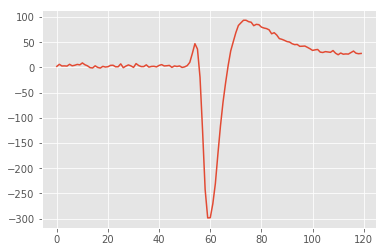

In [11]:
correct_chan.plot()

In [12]:
df = pd.DataFrame({'y_values':correct_chan})
df['diff_reverse'] = np.where(df.y_values.diff(periods=-1) > 0, 'increase', 'decline')
df.head()

,y_values,diff_reverse
0,2.019,decline
1,6.083,increase
2,2.803,decline
3,2.990,increase
4,2.602,decline


In [13]:
peak_amp = df['y_values'].max()
peak_sample = df['y_values'].idxmax()

In [14]:
min_amp = df['y_values'].min()
min_sample = df['y_values'].idxmin()

In [15]:
baseline_amp = peak_amp * 0.1

In [16]:
baseline_sample = df.loc[(df['y_values']<peak_amp) 
                       & (df.index < peak_sample) 
                       & (df['diff_reverse']=='decline') 
                       & (df['y_values']>=baseline_amp), 'y_values'].idxmin()

In [17]:
return_baseline_sample = df.loc[(df['y_values']>min_amp)
                               &(df['y_values']<=baseline_amp)
                               &(df.index>min_sample), 'y_values'].idxmin()

In [18]:
SW_peak = np.absolute(peak_sample - baseline_sample)/30
SW_troff = np.absolute(min_sample - baseline_sample)/30
SW_base = np.absolute(return_baseline_sample - baseline_sample)/30

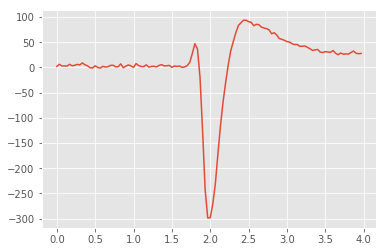

In [19]:
plt.plot(df.index/30, df.y_values)

### TODO:

    - Work around spikes with no positive peak
    - Turn into scirpt (loop over recordings, loop over clusters)